In [1]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

In [25]:
classifier = pipeline('sentiment-analysis', model="wietsedv/bert-base-dutch-cased")

Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import math
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

### Configure

Libraries settings

In [11]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Running settings

In [12]:
LEN_SENTS = 75

### Imports

In [14]:
df = pd.read_csv("dev/hist-aware/notebooks/sentiment/edo_1990s_gas_labeled.csv")
df = df[df.energy == "Y"]

In [15]:
df.shape

(368, 24)

#### Encode labels

In [16]:
cleanup_sentiment = {"sentiment": {"VN": 1, "NG": 2, "NE": 3, "PO": 4, "VP": 5}}
df = df.replace(cleanup_sentiment)

Text(0.5, 0, 'review sentiment')

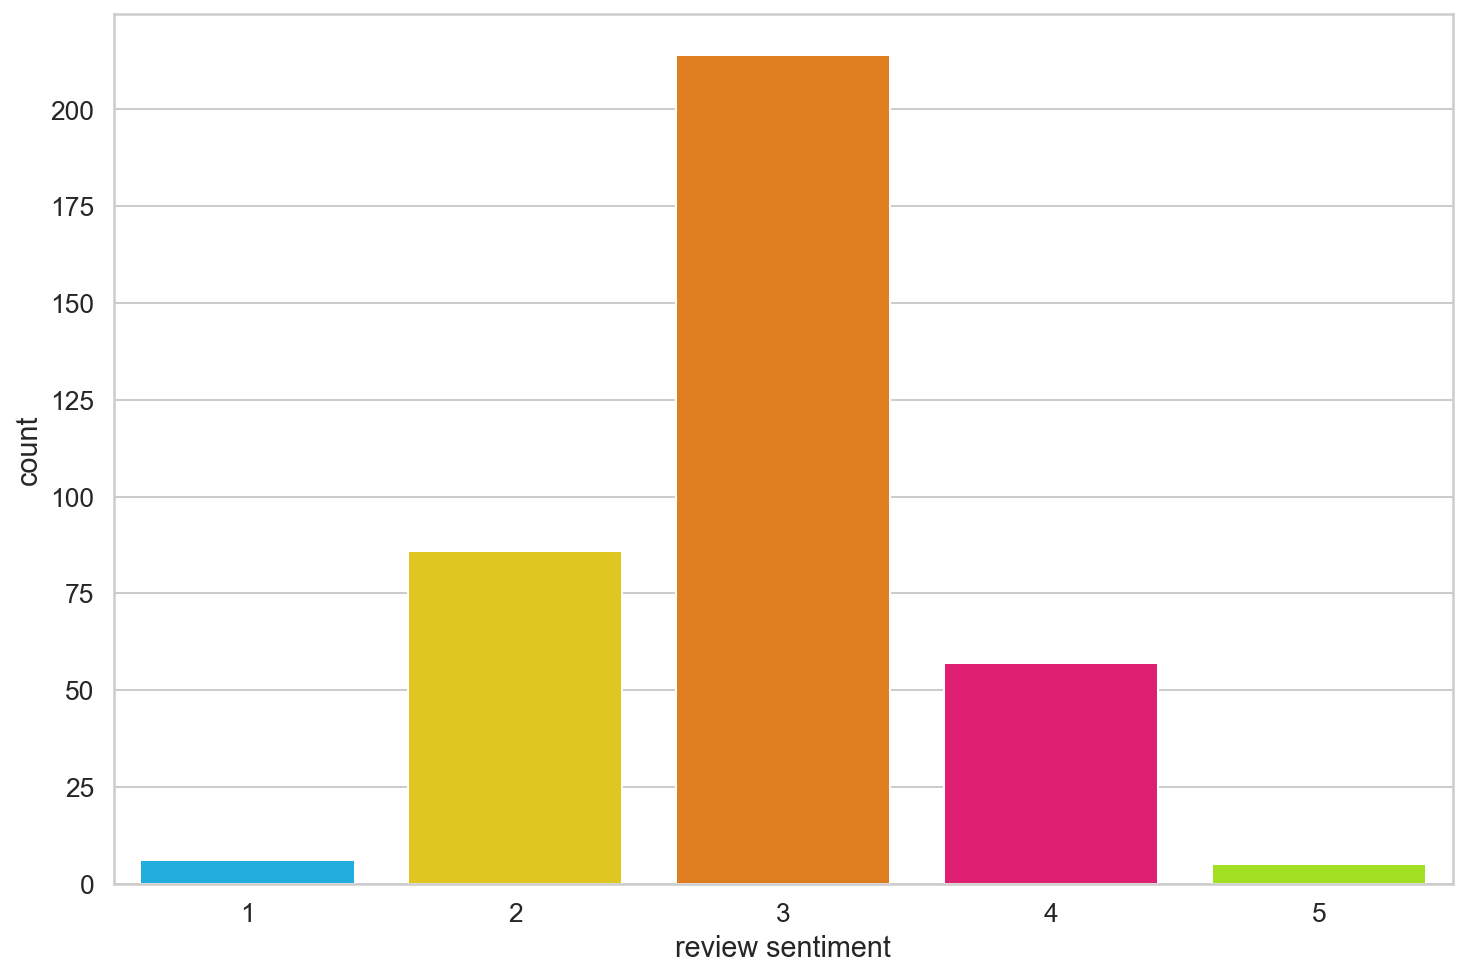

In [17]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')

Reduce from 5 to 3

In [18]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.sentiment.apply(to_sentiment)

Text(0.5, 0, 'review sentiment')

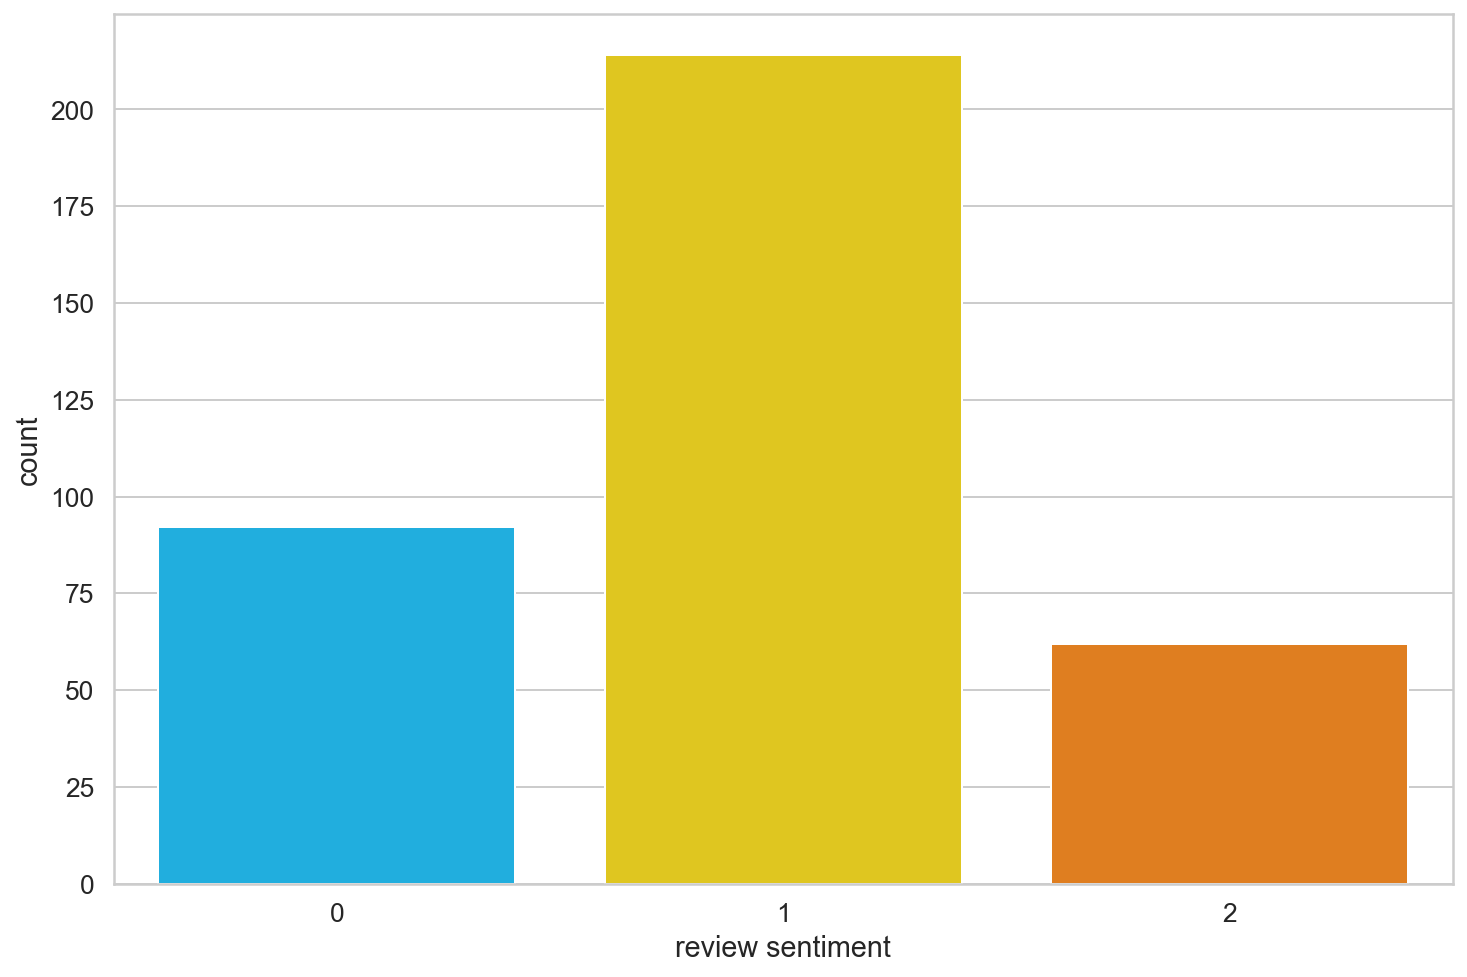

In [19]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')

In [28]:
import nltk.data
from nltk.tokenize import sent_tokenize
from nltk.corpus import alpino

In [29]:
def unite(l, n):
    """Unite sentences previously split using nltk.tokenize."""
    count = []
    chunks = []
    sents = []
    for s in l:
        count.append(len(s.split()))
    value = 0
    prev_idx = 0
    for i in range(0, len(count)):
        if value == 0:
            value = value + count[i]
        elif (i+1 == len(count)):
            chunks.append(l[prev_idx:i])
            value = 0
        elif value >= n:
            chunks.append(l[prev_idx:i])
            prev_idx = i
            value = 0
        else:
             value = value + count[i]
    for c in chunks:
        sents.append(' '.join(c))
    return(sents)

In [30]:
def splitter(s, n):
    """Split sentences only using the number of words."""
    pieces = s.split()
    return [" ".join(pieces[i:i+n]) for i in range(0, len(pieces), n)]

In [31]:
df["text_split"] = df["text"].apply(sent_tokenize)
df["text_split"] = df["text_split"].apply(unite, n = LEN_SENTS)

# Currently not splitting the cleaned sentences
#df["text_clean_split"] = df["text_clean"].apply(splitter, n = LEN_SENTS)

In [45]:
for i, r in df.iterrows():
    res = classifier(r["text_split"])
    labels = []
    result = str
    for i in res:
        if i["label"] == 'LABEL_1':
            labels.append(1)
        else:
            labels.append(0)
        if len(labels) == sum(labels):
            result = "positive"
        elif len(labels) > sum(labels) and sum(labels) != 0:
            result = "split"
        elif sum(labels) == 0:
            result = "negative"
    if result == "positive" and r["sentiment"] == 2:
        print("Got it!")
        print("-------------")
    if result == "split" and r["sentiment"] == 1:
        print("Got it!")
        print("-------------")
    if result == "negative" and r["sentiment"] == 0:
        print("Got it!")
        print("-------------")
    else: 
        print("Didn't get it!")
    print("-------------")

Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Got it!
-------------
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Got it!
-------------
Didn't get it!
-------------
Didn't get it!
-------------
Didn'

KeyboardInterrupt: 